<a href="https://colab.research.google.com/github/GabrielaRomoM/SIGNALS-THEORY_2024-1/blob/main/NNSoundClassificator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Librerias

In [ ]:
from google.colab import drive
from IPython.display import Audio
from scipy.signal import freqz
from sklearn.preprocessing import MinMaxScaler
from scipy.integrate import simps
import seaborn as sns
from scipy.signal import welch
from scipy import signal
import matplotlib.pyplot as plt
import os
import glob
import librosa
import numpy as np
import pandas as pd

#Keras Tuner
!pip install keras-tuner
import tensorflow as tf
from tensorflow import keras
from kerastuner.tuners import RandomSearch
from sklearn.model_selection import train_test_split

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 6.7 MB/s eta 0:00:00


<ipython-input-1-a1a7c1adfea4>:20: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


# Funciones

## Importación Drive, Audios y Etiquetados

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
audios_path = '/content/drive/MyDrive/ANEaudios'
excel_path = '/content/drive/MyDrive/ST_Etiquetado.xlsx'
def audios(audios_path, excel_path, seg=1, fs=44100):
    # Leer el archivo Excel
    df = pd.read_excel(excel_path)

    archivos_audio = glob.glob(os.path.join(audios_path, '**', '*.wav'), recursive=True)
    audios1 = []
    audios0 = []

    # Cargar y clasificar los audios
    for archivo in archivos_audio:
        audio, sr = librosa.load(archivo, sr=fs)

        # Obtener el nombre del archivo sin la ruta
        nombre_archivo = os.path.basename(archivo)

        # Verificar la etiqueta en el Excel
        etiqueta = df.loc[df['Audio'] == nombre_archivo, 'Presencia Señal'].values

        if len(etiqueta) > 0:  # Si se encuentra la etiqueta
            if etiqueta[0] == 1:
               audios1.append(audio)
            elif etiqueta[0] == 0:
                audios0.append(audio)

    # Convertir las listas en matrices numpy
    audios1 = np.array(audios1)
    audios0 = np.array(audios0)

    # Generar el vector de tiempo
    t = np.linspace(0, seg, int(fs * seg))

    return audios1, audios0, t, fs

## Calculo de PSD

In [ ]:
def calc(matrix, fs=44100):
    # Calcula nperseg como el tamaño de la señal (número de muestras)
    s = matrix.shape[1]
    psds = []

    for signal in matrix:
        freq, psd = welch(signal, fs=fs, nperseg=s)
        psds.append(psd)

    psds = np.array(psds)

    return freq, psds

In [ ]:
def promedio(psds):
    promedio = np.mean(psds, axis=0)
    return promedio

## Normalización

In [ ]:
def norm(y):
    """
    Normalización de los datos en base al máximo de presencia de señal
    Entrada: Señal a normalizar
    Salida: Señal normalizada
    """
    y_norm = []
    for i in range(y.shape[0]):  # Recorrer cada señal
        mean = np.mean(y[i])      # Promedio (potencia media)
        scal = mean / np.max(y[i])  # Escalar = media / máximo de la señal
        norm = y[i] / scal         # Normalizar señal
        y_norm.append(norm)

    return np.array(y_norm)

## Histograma

In [ ]:
def calculate_psd_power_ratio(psd_band):
    power_v = np.zeros((psd_band.shape[0]))
    for i in range(psd_band.shape[0]):
        #psd_row = psd_band[i]
        #psd_row_max = np.max(psd_row)
        power_v[i] = np.sum(psd_band[i])
    return power_v

def histkde(psd_ones_band, psd_zeros_band):
    from scipy.stats import norm
    plt.figure(figsize=(12, 6))

    counts1, bins1, _ = plt.hist(psd_ones_power_v, bins=20, alpha=0.7, label='Señal(1)', density=False)
    mean1, std1 = np.mean(psd_ones_power_v), np.std(psd_ones_power_v)
    x1 = np.linspace(min(bins1), max(bins1), 1000)
    p1 = norm.pdf(x1, mean1, std1)
    p1 = p1 * max(counts1) / max(p1)  # Escalar la curva gaussiana
    plt.plot(x1, p1, 'b',linewidth=1)
    plt.legend()

    counts2, bins2, _ = plt.hist(psd_zeros_power_v, bins=300, alpha=0.7, label='Ruido(0)', density=False)
    mean2, std2 = np.mean(psd_zeros_power_v), np.std(psd_zeros_power_v)
    x2 = np.linspace(min(bins2), max(bins2), 1000)
    p2 = norm.pdf(x2, mean2, std2)
    p2 = p2 * max(counts2) / max(p2)  # Escalar la curva gaussiana
    plt.plot(x2, p2, 'g',linewidth=1)
    plt.legend()

    # Add labels, legend, and grid
    plt.xlabel("Potencia Promedio")
    plt.ylabel("Densidad de Probabilidad (KDE)")
    #plt.xlim(0,5)
    plt.title("Histograma PSD")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

## Espectograma

In [ ]:
def compute_spectrograms(audio_ones, audio_zeros, fs, max_freq=8000):
  def process_audio(audio_data):
    spectrograms = []
    for audio in audio_data:
      # Compute spectrogram
      f, t, Sxx = signal.spectrogram(audio.flatten(), fs, nperseg=512, noverlap=32)

      # Limit frequency range
      freq_mask = f <= max_freq
      f = f[freq_mask]
      Sxx = Sxx[freq_mask]

      # Convert to dB scale
      Sxx_db = 10 * np.log10(Sxx)

      spectrograms.append(Sxx_db)

    return f, t, np.array(spectrograms)

  # Compute spectrograms for audio_ones
  f,t,spectrograms1 = process_audio(audios1)

  # Compute spectrograms for audio_zeros
  f,t,spectrograms0 = process_audio(audios0)

  return f,t,spectrograms1, spectrograms0

def spectrogram(y):
    plt.figure(figsize=(16,5))
    plt.subplot(1,2,1)
    plt.pcolormesh(t,f, spectrograms1[y])
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.title('Señal')
    plt.subplot(1,2,2)
    plt.pcolormesh(t,f, spectrograms0[y])
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.title('Ruido')
    plt.show()

# Resultados

## Ejecucción

In [ ]:
audios1, audios0, t, fs = audios(audios_path, excel_path, seg=1, fs=44100)

print('audios1:', audios1.shape)
print('audios0:', audios0.shape)

audios1: (390, 83886)
audios0: (815, 83886)


In [ ]:
#PSD
f1, audios_1 = calc(audios1, fs=fs)
f0, audios_0 = calc(audios0, fs=fs)

In [ ]:
#PSD Normalizado
audios_01 = norm(audios_1)
audios_00 = norm(audios_0)

In [ ]:
# Promedio de las PSD sin normalizar
prom_1 = promedio(audios_1)
prom_0 = promedio(audios_0)

# Promedio de las PSD normalizadas
prom1 = promedio(audios_1)
prom0 = promedio(audios_0)

## Veriificación audio

In [ ]:
#Audio
Audio(audios1[30],rate=fs)

## Gráficas

(1e-05, 0.01)

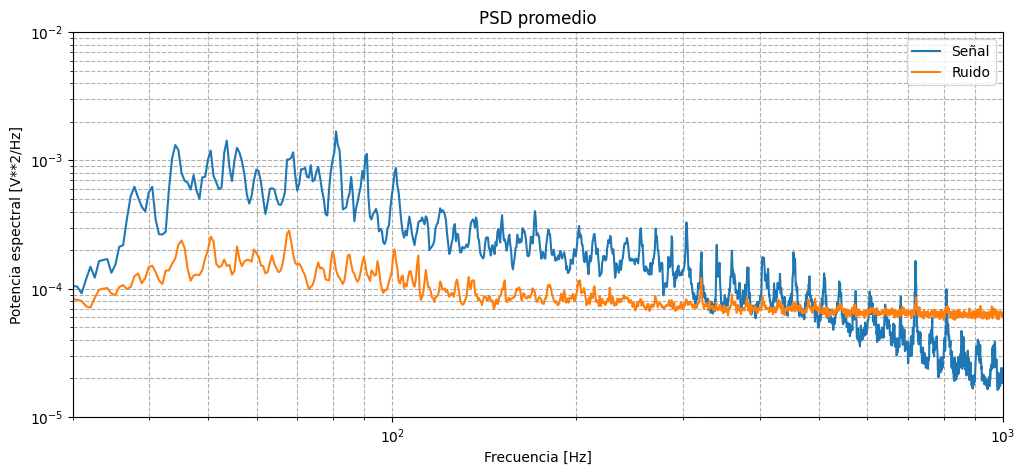

In [ ]:
#Grafico PSD sin normalizar
plt.figure(figsize=(12,5))
plt.loglog(f1, prom_1)
plt.loglog(f1, prom_0)
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Potencia espectral [V**2/Hz]')
plt.legend(['Señal','Ruido'])
plt.title('PSD promedio')
plt.grid(True, which="both", ls="--")
plt.xlim(30,1000)
plt.ylim(10**-5,10**-2)

## Histograma

In [ ]:
psd_ones_power_v = calculate_psd_power_ratio(audios_1)
psd_zeros_power_v = calculate_psd_power_ratio(audios_0)

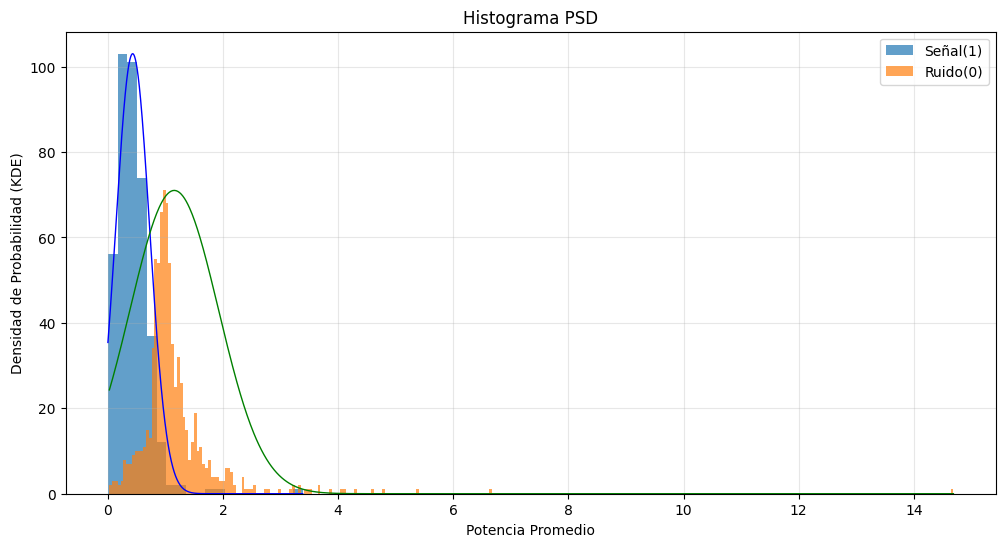

In [ ]:
histkde(audios_1, audios_0)

## Espectogramas

In [ ]:
f,t,spectrograms1, spectrograms0 = compute_spectrograms(audios1, audios0, fs)
print(f"Dimension de la matriz de Señal = {spectrograms1.shape}\nDimension de la matriz de Ruido = {spectrograms0.shape}")

Dimension de la matriz de Señal = (390, 93, 174)
Dimension de la matriz de Ruido = (815, 93, 174)


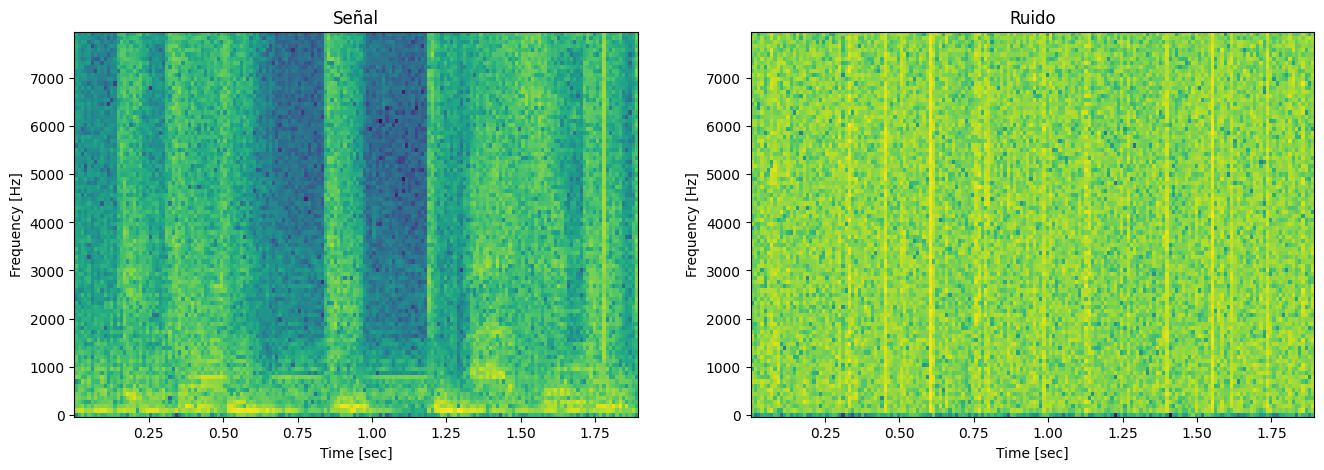

In [ ]:
spectrogram(100)

# Red Convolucional

## Función para Keras Tuner y Red CNN

In [ ]:
def prepare_data(spectrograms1, spectrograms0):
    # Combine signal and noise spectrograms
    X = np.concatenate((spectrograms1, spectrograms0), axis=0)

    # Create labels: 1 for signal, 0 for noise
    y = np.concatenate((np.ones(len(spectrograms1)), np.zeros(len(spectrograms0))))

    # Reshape if necessary and add channel dimension
    if len(X.shape) == 3:
        X = X.reshape((*X.shape, 1))

    # Normalize the data
    X = (X - np.mean(X)) / np.std(X)

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    return X_train, X_test, y_train, y_test

def build_model(hp):
    model = keras.Sequential([
        keras.layers.Conv2D(
            filters=hp.Int('conv_1_filter', min_value=16, max_value=64, step=16),
            kernel_size=hp.Choice('conv_1_kernel', values=[3, 5]),
            activation='relu',
            input_shape=X_train.shape[1:]),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Dropout(rate=0.4),    # Dropout layer
        keras.layers.Conv2D(
            filters=hp.Int('conv_2_filter', min_value=32, max_value=64, step=16),
            kernel_size=hp.Choice('conv_2_kernel', values=[3, 5]),
            activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Dropout(rate=0.4),
        keras.layers.Flatten(),
        keras.layers.Dense(
            units=hp.Int('dense_1_units', min_value=32, max_value=64, step=16),
            activation='relu'),
        keras.layers.Dropout(rate=0.3),
        keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(hp.Float('learning_rate', min_value=1e-5, max_value=1e-3, sampling='log')),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

## Entrenamiento Modelo

In [ ]:
# Prepare the data
X_train, X_test, y_train, y_test = prepare_data(spectrograms1, spectrograms0)

# Create and run the tuner
tuner = RandomSearch(
    build_model,
    objective='loss',
    max_trials=8,
    directory='audio_classification_tuner',
    project_name='audio_cnn_optimized'
)

tuner.search(
    X_train, y_train,
    epochs=20,
    validation_split=0.2,
    callbacks=[keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)]
)

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Train the best model
history = best_model.fit(
    X_train, y_train,
    epochs=50,
    validation_split=0.2,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)
    ]
)

Trial 8 Complete [00h 00m 15s]
loss: 0.1685294359922409

Best loss So Far: 0.05207860842347145
Total elapsed time: 00h 03m 22s
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 160ms/step - accuracy: 0.9640 - loss: 0.0934 - val_accuracy: 0.9172 - val_loss: 0.1800 - learning_rate: 6.5345e-04
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9811 - loss: 0.0570 - val_accuracy: 0.9053 - val_loss: 0.1809 - learning_rate: 6.5345e-04
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9945 - loss: 0.0321 - val_accuracy: 0.9349 - val_loss: 0.1721 - learning_rate: 6.5345e-04
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9909 - loss: 0.0366 - val_accuracy: 0.9349 - val_loss: 0.1673 - learning_rate: 6.5345e-04
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9984 - loss: 0.0182 - val_accuracy: 0.9053 - val_loss: 0.2006 - learning_rate: 6.5345e-04
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9942 - loss: 0.0200 - val_accuracy: 0.8994 - val_loss: 0.2354 - learning_rate: 6.5345e-04
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9925 - loss: 0.

## Predicción

In [ ]:
def display_spectrograms_with_predictions(X_test, y_test, y_pred, num_examples=5):
    # Choose random indices
    indices = np.random.choice(len(X_test), num_examples, replace=False)

    # Set up the plot
    fig, axes = plt.subplots(num_examples, 1, figsize=(5, 4*num_examples))
    if num_examples == 1:
        axes = [axes]

    for i, idx in enumerate(indices):
        # Get the spectrogram
        spectrogram = X_test[idx].squeeze()

        # Get true and predicted labels
        true_label = y_test[idx]
        pred_prob = y_pred[idx][0]
        pred_label = int(pred_prob > 0.5)

        # Display the spectrogram
        im = axes[i].imshow(spectrogram, aspect='auto', origin='lower', cmap='viridis')
        axes[i].set_title(f"True: {true_label}, Pred: {pred_label} (Prob: {pred_prob:.2f})")
        axes[i].set_ylabel('Frequency Bin')

        # Only set xlabel for the last subplot
        if i == num_examples - 1:
            axes[i].set_xlabel('Time Frame')

    plt.tight_layout()
    plt.show()

# Resultado Entrenamiento

In [ ]:
# Evaluate the model
evaluation = best_model.evaluate(X_test, y_test)
best_model.summary()

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9411 - loss: 0.1106


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 91, 172, 64)         │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 45, 86, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 45, 86, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 43, 84, 48)          │          27,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 21, 42, 48)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 21, 42, 48)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 42336)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       2,709,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,213,909 (31.33 MB)

 Trainable params: 2,737,969 (10.44 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,475,940 (20.89 MB)

In [ ]:
# Save the model
best_model.save('audio_classification_cnn_optimized.keras')

## Cargar Modelo Entrenado

In [ ]:
from keras.models import load_model

# Load the model from the 'saved_model' directory
model = load_model('audio_classification_cnn_optimized.keras')

## Predicción

In [ ]:
# Make predictions on the test set
y_pred = best_model.predict(X_test)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


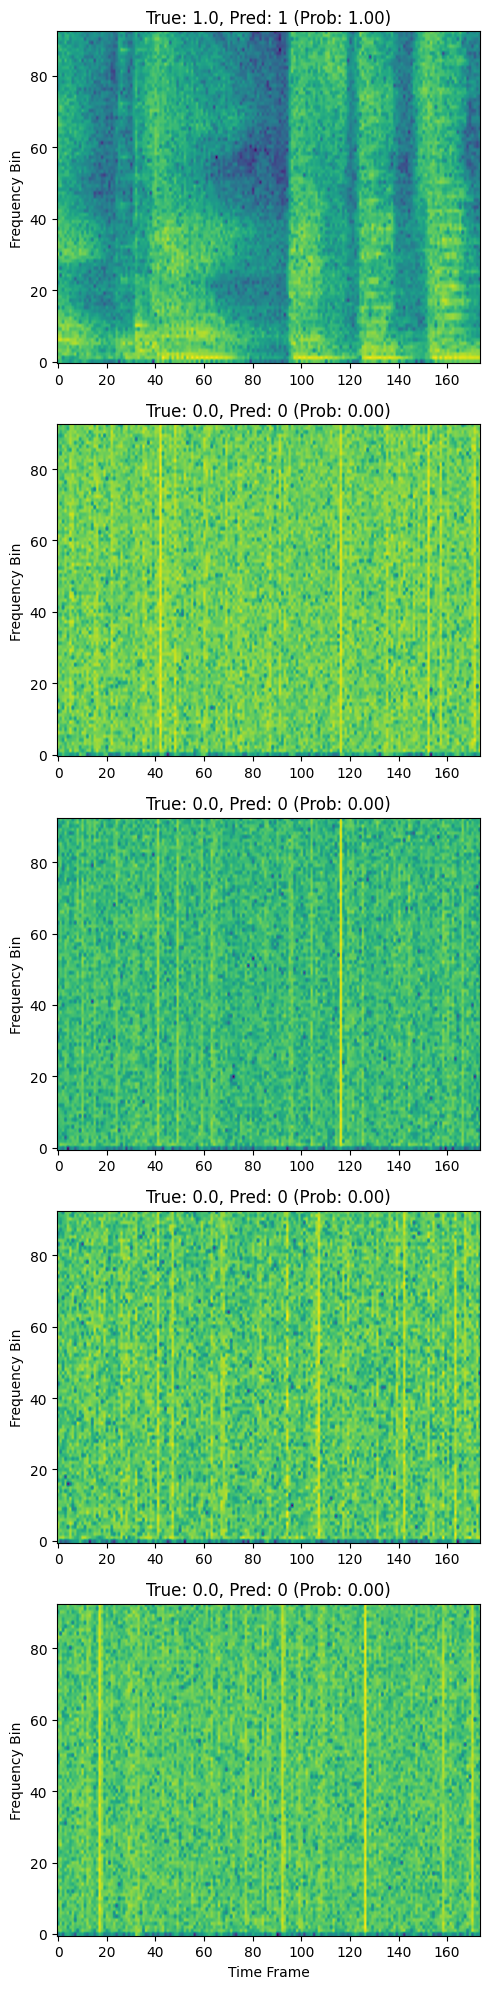

In [ ]:
display_spectrograms_with_predictions(X_test, y_test, y_pred, num_examples=5)